In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eye-images-and-hb-level/Eye_Features.xlsx
/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked/1709720371526.jpg
/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked/1709800783595.jpg
/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked/1709980654965.jpg
/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked/1709709970921.jpg
/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked/1709970267160.jpg
/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked/1709985657508.jpg
/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked/1710049249967.jpg
/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked/1709880362990.jpg
/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked/1709789649074.jpg
/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked/1710050083980.jpg
/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked/1710067886551.jpg
/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked/1709880494391.jpg
/kaggle/

In [2]:
import pandas as pd 
df = pd.read_excel('/kaggle/input/eye-images-and-hb-level/Eye_Features.xlsx')
df = df[['Image_Name','Hb Value']]
df.head()

,Image_Name,Hb Value
0,1709617490220.jpg,11.5
1,1709617782204.jpg,11.6
2,1709618916134.jpg,11.1
3,1709619661748.jpg,12.1
4,1709620146694.jpg,12.2


In [3]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.176, random_state=42)

In [4]:
print('train_df shape',train_df.shape)
print('test_df shape',test_df.shape)
print('tval_df shape',val_df.shape)

train_df shape (282, 2)
test_df shape (61, 2)
tval_df shape (61, 2)


In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

def load_image_and_label(image_file, label):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # ResNet50 expects 224x224
    # Scale pixel values [0, 1] or standardize them
    image = image / 255.0
    return image, label

def create_tf_dataset(df, images_folder, batch_size=8, shuffle=True):
    # Construct full paths to images
    image_paths = [os.path.join(images_folder, img) for img in df['Image_Name'].values]
    labels = df['Hb Value'].values.astype(np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_ds = create_tf_dataset(train_df, "/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked", batch_size=16, shuffle=True)
val_ds   = create_tf_dataset(val_df,   "/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked", batch_size=16, shuffle=False)
test_ds  = create_tf_dataset(test_df,  "/kaggle/input/eye-images-and-hb-level/Eye Masked/Eye Masked", batch_size=16, shuffle=False)


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def build_model(input_shape=(224, 224, 3)):
    # Load ResNet50 without the top classification layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    # for layer in base_model.layers:
    #     layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add your own fully connected layers if desired
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.3)(x)

    # Final regression output (1 dimension: predicted Hb)
    predictions = Dense(1, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [7]:
model = build_model(input_shape=(224, 224, 3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',  # or 'mae'
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [8]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 65.9782 - mean_absolute_error: 6.9399 - val_loss: 94.7514 - val_mean_absolute_error: 9.6342
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 7.8987 - mean_absolute_error: 2.2342 - val_loss: 111.1986 - val_mean_absolute_error: 10.4531
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 3.5067 - mean_absolute_error: 1.4372 - val_loss: 117.7890 - val_mean_absolute_error: 10.7638
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 1.7238 - mean_absolute_error: 1.0520 - val_loss: 119.3759 - val_mean_absolute_error: 10.8372
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 1.8689 - mean_absolute_error: 1.0333 - val_loss: 121.0243 - val_mean_absolute_error: 10.9130
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 1.5653 - mean_absolute_error: 0.9714 - val_loss: 122.4424 - val_mean_absolute_error: 10.9778
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 1.0202 - mean_absolute_error: 

In [9]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.2306 - mean_absolute_error: 0.3937 - val_loss: 21.2184 - val_mean_absolute_error: 4.0048
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.2070 - mean_absolute_error: 0.3750 - val_loss: 18.6091 - val_mean_absolute_error: 3.7122
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.2988 - mean_absolute_error: 0.4550 - val_loss: 17.3466 - val_mean_absolute_error: 3.5776
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.1465 - mean_absolute_error: 0.2984 - val_loss: 14.9538 - val_mean_absolute_error: 3.2465
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.2294 - mean_absolute_error: 0.3926 - val_loss: 13.4484 - val_mean_absolute_error: 3.0474
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.1638 - mean_absolute_error: 0.3306 - val_loss: 9.9962 - val_mean_absolute_error: 2.5197
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.1330 - mean_absolute_error: 0.290

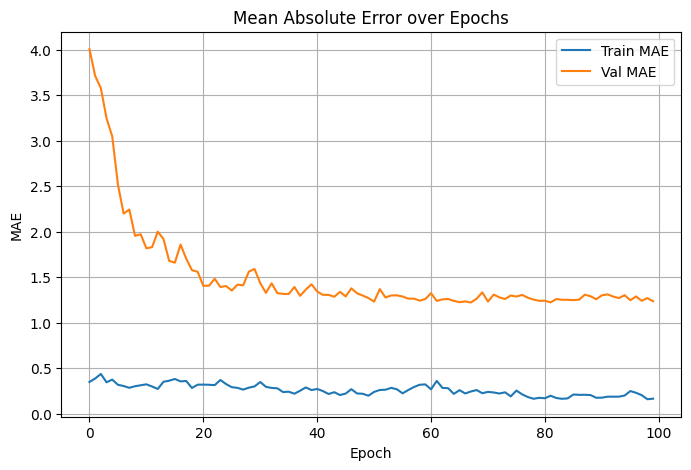

In [10]:
import matplotlib.pyplot as plt

# 1. Retrieve MAE values
train_mae = history.history['mean_absolute_error']       # Training MAE per epoch
val_mae   = history.history['val_mean_absolute_error']   # Validation MAE per epoch

# 2. Plot
plt.figure(figsize=(8, 5))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Save your model in HDF5 format
model.save("my_model.h5")

In [12]:
test_loss, test_mae = model.evaluate(test_ds)
print("Test MAE:", test_mae)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.8623 - mean_absolute_error: 1.6823
Test MAE: 1.5732449293136597


In [14]:
def build_model_unfreezed(input_shape=(224, 224, 3)):
    # Load ResNet50 without the top classification layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add your own fully connected layers if desired
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.3)(x)

    # Final regression output (1 dimension: predicted Hb)
    predictions = Dense(1, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [15]:
model = build_model_unfreezed(input_shape=(224, 224, 3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',  # or 'mae'
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


In [16]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 56.5366 - mean_absolute_error: 6.5226 - val_loss: 88.6781 - val_mean_absolute_error: 9.3140
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 10.4428 - mean_absolute_error: 2.2913 - val_loss: 102.1771 - val_mean_absolute_error: 10.0123
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 4.1020 - mean_absolute_error: 1.5442 - val_loss: 117.8154 - val_mean_absolute_error: 10.7650
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 2.6432 - mean_absolute_error: 1.2452 - val_loss: 126.0033 - val_mean_absolute_error: 11.1388
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 1.4651 - mean_absolute_error: 0.9295 - val_loss: 130.0564 - val_mean_absolute_error: 11.3193
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 1.8548 - mean_absolute_error: 1.0837 - val_loss: 130.9310 - val_mean_absolute_error: 11.3578
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 1.2796 - mean_absolute

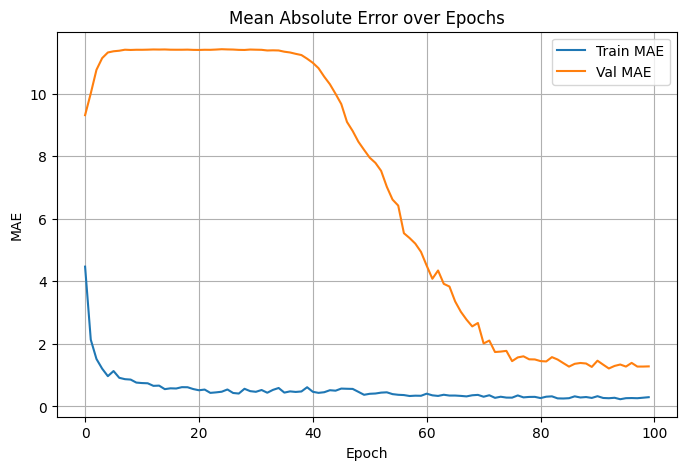

In [17]:
import matplotlib.pyplot as plt

# 1. Retrieve MAE values
train_mae = history.history['mean_absolute_error']       # Training MAE per epoch
val_mae   = history.history['val_mean_absolute_error']   # Validation MAE per epoch

# 2. Plot
plt.figure(figsize=(8, 5))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
model.save('resnet50_eye_unfreezed.h5')

In [19]:
def build_model_unfreezed_custom(input_shape=(224, 224, 3)):
    # Load ResNet50 without the top classification layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add your own fully connected layers if desired
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Final regression output (1 dimension: predicted Hb)
    predictions = Dense(1, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [20]:
model = build_model_unfreezed(input_shape=(224, 224, 3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',  # or 'mae'
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


In [21]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 67.3489 - mean_absolute_error: 7.1205 - val_loss: 85.8203 - val_mean_absolute_error: 9.1593
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 7.2487 - mean_absolute_error: 2.1194 - val_loss: 113.1173 - val_mean_absolute_error: 10.5445
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 3.1676 - mean_absolute_error: 1.4451 - val_loss: 126.8553 - val_mean_absolute_error: 11.1770
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 2.2463 - mean_absolute_error: 1.2138 - val_loss: 132.3228 - val_mean_absolute_error: 11.4190
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 1.2214 - mean_absolute_error: 0.8740 - val_loss: 132.8400 - val_mean_absolute_error: 11.4416
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 1.0397 - mean_absolute_error: 0.8075 - val_loss: 131.9062 - val_mean_absolute_error: 11.4007
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 1.0766 - mean_absolute_

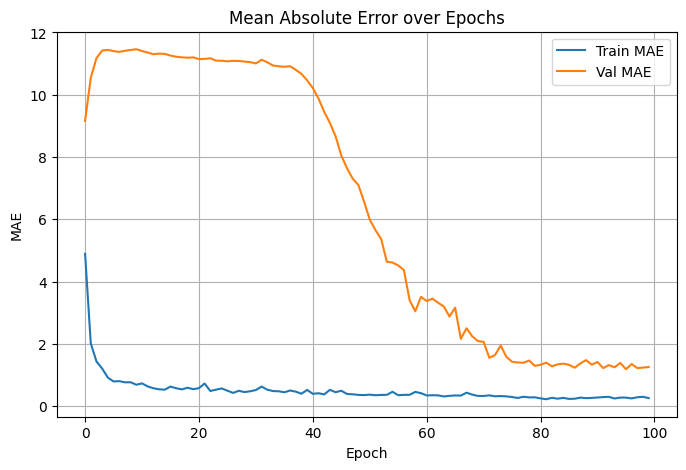

In [22]:
import matplotlib.pyplot as plt

# 1. Retrieve MAE values
train_mae = history.history['mean_absolute_error']       # Training MAE per epoch
val_mae   = history.history['val_mean_absolute_error']   # Validation MAE per epoch

# 2. Plot
plt.figure(figsize=(8, 5))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
model.save('resnet50_eye_unfreezed_custum.h5')